In [28]:
import ee
import geemap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from osgeo import gdal

from mpl_toolkits.mplot3d import Axes3D
import geemap.colormaps as cm

# import seaborn as sns
# import geopandas as gpd

import datetime

In [29]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

# Spectral Change

This notebook utilizes Google Earth Engine to view trends in spectral indices over time. The temporal trends can be seasonal (one year) or over many years. Additionally, you can calculate the "trend of the trend" to evaluate the rate at which spectral change is occuring. 

You may also perform a KMeans cluster on the different spectral trends.

# Functions

In [30]:
def maskS2clouds(image):
    """ Mask cloud and cirrus pixels from Sentinel-2 imagery using QA60 band.

        Parameters:
        image (Image): A single Image in an ImageCollection or standalone Image

        Returns:
        Image with masked features removed and original metadata

    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0)) # performs bitwise AND operation between QA60 band and cloud bitmask

    return image.updateMask(mask) \
        .divide(10000) \
        .copyProperties(image, ['system:time_start']) 

def maskWater(image):
    ''' Mask out water using MODIS data.
    
        Define waterMask prior to running.

        Returns: 
        Image with pixels where water_mask < 1. '''
    
    return image.updateMask(waterMask.select('water_mask').lt(1))


def maskS2snow(image):
    ''' Mask snow from Sentinel-2 imagery with MSK_SNWPRB (snow probability mask).

        Returns: 
        Image with pixels where MSK_SNWPRB < 0.9%. '''
    
    mask = image.select('MSK_SNWPRB').lt(0.009)
    
    return image.updateMask(mask).copyProperties(image, ['system:time_start'])

def maskWhite(image):
    ''' Masks white pixels to ensure all cloudy or snowy pixels are removed.

        Returns: 
        Image with pixels where grayscale is greater than or equal to 2000 are removed. '''

    # convert RGB values to grayscale
    grayscale = image.expression(
            '(.3 * 1e4 * R) + (.59 * 1e4 * G) + (.11 * 1e4 * B)', {
            'R': image.select('B4'),
            'G': image.select('B3'),
            'B': image.select('B2')
        })
    
    white_mask = grayscale.lte(2000)

    return image.updateMask(white_mask).copyProperties(image,['system:time_start'])

def clp(image):
    '''Clips a single Image to a region of interest'''
    return image.clip(aoi)

def addNDVI(image):
    '''Adds S2's NDVI band to each image (in an ImageCollection)'''
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi).copyProperties(image, ['system:time_start'])

def annual_images(y):
    ''' Filters an image collection for a specific year (y) and date range (start and end month).
        Applies the chosen analysis (mean, min, max, or median) to calculate the statistics for the images in that year.
        
        Requires:
        index_collection, start_month, end_month, and analysis.
    
        Parameters: 
        y: a given year

        Returns:
        Statistcs over the image within the date range.
    '''
    # filter for given year
    range_year = ee.Filter.calendarRange(y, y, 'year')
    #filter for specified month range
    range_month = ee.Filter.calendarRange(start_month, end_month, 'month')

    # filter image collection by year and month and add a time band
    filtered_dataset = (index_collection
                        .filter(range_year)
                        .filter(range_month)
                        .map(lambda image: image.addBands(image.metadata('system:time_start').divide(3.154e10)))) # Needed for linear regression 
        
    # Print out the number of images in the filtered dataset
    num_images = filtered_dataset.size()
    
    # Choose the reducer based on the chosen analysis
    if analysis == 'mean':
        reducer = ee.Reducer.mean().combine( # calculates average value for each pixel across all images
            reducer2=ee.Reducer.stdDev(), # calculates standard deviation
            sharedInputs=True
        )

    elif analysis == 'min' or analysis == 'max':
        reducer = ee.Reducer.mean().combine( # calculates minimum and maximum values
            reducer2=ee.Reducer.minMax(),#
            sharedInputs=True
        )
    elif analysis == 'median':
        reducer = ee.Reducer.mean().combine( # calculates middle value for each pixel
            reducer2=ee.Reducer.median(),
            sharedInputs=True
        )

    # Use the combined reducer to get the statistics
    stats = filtered_dataset.reduce(reducer)
    return stats.set('year', y).set('num', num_images)
    

def intrayear(index_collection):
    ''' Filter Image Collection within a single year. Used for seasonal (one-year) trends.

        Function is used when start_year = end_year.

        Requires: 
        index_collection, start_month, end_month, start_year, and end_year.

        Parameters: 
        index_collection: an ImageCollection containing images with a chosen index

        Returns:
        filtered_dataset: Filtered Image Collection
    '''
    
    range_year = ee.Filter.calendarRange(start_year, end_year, 'year')
    range_month = ee.Filter.calendarRange(start_month, end_month, 'month')
    
    # add a time band with the year to each image 
    filtered_dataset = (index_collection
                        .filter(range_year)
                        .filter(range_month)
                        .map(lambda image: image.addBands(image.metadata('system:time_start').divide(3.154e10)))) # Needed for linear regression 
    
    num_images = filtered_dataset.size()

    return filtered_dataset.set('year', start_year).set('num', num_images)


def annual_trend(y):
    ''' Calculate temporal trend for an index (NDVI) within a specified date range.
        Applies a linear regression to analyze the trend of changes over time for the chosen index.
        aka the trend of the trend!

        Requires:
        index_collection, start_month, and end_month.
    
        Parameters: 
        y: a given year

        Returns:
        Statistcs over the image within the date range.
    '''
    range_year = ee.Filter.calendarRange(y, y, 'year')
    range_month = ee.Filter.calendarRange(start_month, end_month, 'month')
   
   # add a time band with the year to each image 
    filtered_dataset = (index_collection
                        .filter(range_year)
                        .filter(range_month)
                        .map(lambda image: image.addBands(image.metadata('system:time_start').divide(3.154e10)))) # Needed for linear regression 
    
    # Print out the number of images in the ImageCollection for each year
    num_images = filtered_dataset.size()
    
    # Use the combined reducer to get the statistics
    stats = filtered_dataset.reduce(reducer = ee.Reducer.linearFit())
    return stats.set('year', y).set('num', num_images)

def createTimeBand(image):   
    '''Adds a time band to the image using metadata'''
    return image.addBands(image.metadata('system:time_start').divide(3.154e10))

def meanNDVI(image): 
    ''' Calculates the mean NDVI within a specific region.
        
        Requires:
        ndvi, aoi

        Returns:
        Image with property 'ndvi_mean'. '''
    
    ndvi = image.select('NDVI')
    ndvi_mean = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10
    ).get('NDVI')

    ndvi_mean = ee.Number(ndvi_mean)
    
    return image.set('ndvi_mean', ndvi_mean)

# Build collection


Idea here is to locate Sentinel-2 images that (1) completely fall within the AOI and clip the images to the AOI, (2) pass through various cloud/snow/etc filters, and then (3) mask clouds, water, etc. and (4) calculate pixelwise NDVI for each image and add it as a band

### Define AOI and build image collection. Choose a cell to use HYBAS watershed boundaries, coordinates, or upload a geoJSON.

In [31]:
# We would normally feed the script a list of watershed IDs and select it from a database stored on Earth Engine

HYBAS_ID = 8100362560

aoi = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_10").filter(ee.Filter.eq('HYBAS_ID', HYBAS_ID))


In [32]:

long = aoi.geometry().centroid().coordinates().get(0).getInfo()
lat = aoi.geometry().centroid().coordinates().get(1).getInfo()


# Load dataset

Adjust the years and months for the desired time range. 
Adjust CLOUDY_PIXEL_PERCENTAGE for desired cloudiness.

In [33]:
# Get water mask
waterMask = (
    ee.ImageCollection('MODIS/006/MOD44W') 
    .filter(ee.Filter.date('2015-01-01', '2015-01-02')) 
    .select('water_mask') \
    .first()
)
# Get Sentinel 2 harmonized images
dataset = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                #  Filter by year
                  .filter(ee.Filter.calendarRange(2019,2023,'year'))
                #  Filter by month
                  .filter(ee.Filter.calendarRange(6,9,'month'))
                #  Pre-filter to get less cloudy granules.
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
                  .filterBounds(aoi)
                #   // This one's Toolik
                # .filterBounds(ee.Geometry.Point(-149.5427, 68.6267).buffer(500))
                #   // This one's Russian tree tracks
                # .filterBounds(ee.Geometry.Point(133.16008, 66.82386).buffer(1000))
                  .map(clp)
                  .map(maskS2clouds)
                  .map(maskS2snow)
                  .map(maskWhite)
                  .map(maskWater)
                  .map(addNDVI)
)

In [34]:
Map = geemap.Map(center = (lat, long), zoom = 11)

# View pixelwise trend of annual mean NDVI

Steps are (1) group images by year (2) find the pixelwise maximum NDVI for each year (3) calculate the trend of that pixelwise maximum for the record (i.e. find pixels that are "greening" and "browning" since 2019)

In [35]:
# Pick your index
index = 'NDVI'
# Choose 'mean', 'median', 'min', or 'max' for analysis
analysis = 'max'  

# limit beyond your ImageCollection
start_year = 2019
end_year = 2024
start_month = 6
end_month = 8

# image collection with index band
index_collection = dataset.select(index)  

# Generate list of years
years = ee.List.sequence(start_year, end_year)

In [38]:
if start_year == end_year:
    intrayear_collection = intrayear(index_collection)

    item = intrayear_collection.getInfo()
    print("Year:", item['properties']['year'], "Number of images:", item['properties']['num'])

    # Get linear fit to pixelwise trend of annual max NDVI
    trend = intrayear_collection.select(['system:time_start',
                                index
                                ]).reduce(ee.Reducer.linearFit())

else:

    # Map over years to get yearly statistics
    yearwise_ndvi = years.map(annual_images)

    for item in yearwise_ndvi.getInfo():
        print("Year:", item['properties']['year'], "Number of images:", item['properties']['num'])

        yearCompCol = ee.ImageCollection.fromImages(yearwise_ndvi)

        # Get linear fit to pixelwise trend of annual max NDVI
        trend = yearCompCol.select(['system:time_start_mean',
                                    f'{index}_{analysis}'
                                    ]).reduce(ee.Reducer.linearFit())



Year: 2019 Number of images: 8
Year: 2020 Number of images: 12
Year: 2021 Number of images: 6
Year: 2022 Number of images: 7
Year: 2023 Number of images: 6
Year: 2024 Number of images: 0


### Map

Find the min and max values of the trend, which will be used as the min and max values of the colorbar.

In [46]:
scale = trend.select('scale')

tMin = scale.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=500,  # Adjust the scale depending on your resolution
    maxPixels=1e9
).getInfo()['scale']

tMax = scale.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=500,  # Adjust the scale depending on your resolution
    maxPixels=1e9
).getInfo()['scale']


Set image limit to the number of images you would like to view.

In [47]:
image_limit = 5

# view RGB
for image_id in intrayear(dataset).aggregate_array("system:index").getInfo()[0:image_limit]:
        image = intrayear(dataset).filterMetadata("system:index", "equals", image_id).first()
        
        image_RGB = image.select('B4', 'B3', 'B2') 
        RGB_vis_params = {'min': 0.0, 'max': 0.3}
        Map.addLayer(image_RGB, RGB_vis_params, ee.Image(image).date().format('yyyy-MM-dd').getInfo(), True)

# view NDVI
# for image_id in intrayear_collection.aggregate_array("system:index").getInfo()[0:image_limit]:
#         image = intrayear_collection.filterMetadata("system:index", "equals", image_id).first()
#         date_string = ee.Image(image).date().format('yyyy-MM-dd').getInfo()

#         Map.addLayer(image.select('NDVI'), {}, f'{date_string}_NDVI', False)

# view trend
Map.addLayer(trend.select('scale'),
              {'min': tMin, 'max': tMax,
            'palette': ['red', 'white', 'blue']
            },
 'trend')

# add colorbar for trend
Map.add_colorbar_branca(colors=['red', 'white', 'blue'], vmin=tMin, vmax=tMax, layer_name='trend')

Map

Map(center=[69.43868522743487, -143.87528563530208], controls=(WidgetControl(options=['position', 'transparent…

# Get pixelwise data and use it to analyze/visualize

In this example we just get the mean NDVI for each image in the record for the AOI 

In [48]:
clp_collection = index_collection.map(clp)

# average NDVI
ndvi_collection = clp_collection.map(meanNDVI)

In [49]:
image_list = ndvi_collection.getInfo()
data = []

# add date and mean NDVI to data frame
for img in image_list['features']:
    properties = img['properties']
    data.append({
            'date': ee.Date(properties['system:time_start']).format('YYYY-MM-dd').getInfo(),
            'ndvi_mean': properties.get('ndvi_mean')
        })
    
df = pd.DataFrame(data, columns=['date', 'ndvi_mean'])

In [68]:
# convert date to datetime
df['date'] = pd.to_datetime(df['date'])

df['doy'] = df['date'].dt.dayofyear
df['year'] = df['date'].dt.year

# add ordinal date column to assist with plotting
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

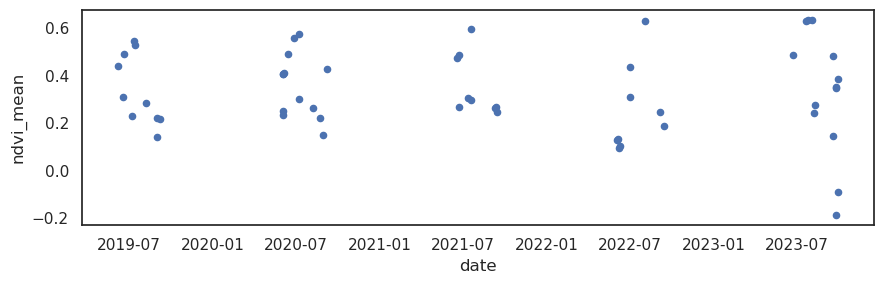

In [69]:
fig, ax = plt.subplots(figsize=(9,3))
df.plot.scatter(x='date', y='ndvi_mean', ax=ax)
fig.tight_layout()

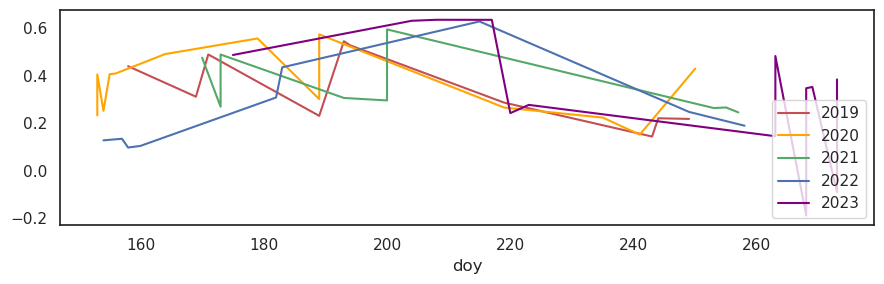

In [80]:
fig, ax = plt.subplots(figsize=(9,3))
colors = {
    2019:'r',
    2020:'orange',
    2021:'g',
    2022:'b',
    2023 : 'purple'
}
for year, group in df.groupby(by='year'):
    group.plot(x='doy', y='ndvi_mean', label=year, color=colors[year], ax=ax)
fig.tight_layout()